In [8]:
import os
import numpy as np
import pandas as pd
import PySAM.Pvsamv1 as pv
import matplotlib.pyplot as plt
import urllib.request

## Load Profile

Getting our load profile

In [9]:
data_path = os.path.abspath("../data")

our_load_profile = np.loadtxt(os.path.join(data_path, "Max_load_profile_for_year.txt"), skiprows=1)

In [13]:
# Declare all variables as strings. Spaces must be replaced with '+', i.e., change 'John Smith' to 'John+Smith'.
# Define the lat, long of the location and the year
#lat, lon, year = 47.65,-122.3,2019
# You must request an NSRDB api key from the link above
api_key = 'dYmj0MPsG0ngTV1VdHqmTUEe4TPX9fxIS45FsOal'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle'
# Choose year of data
#year = '2019'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '60'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'Cassidy+Quigley'
# Your reason for using the NSRDB.
reason_for_use = 'beta+testing'
# Your affiliation
your_affiliation = 'University+of+Washington'
# Your email address
your_email = 'ccq@uw.edu'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'false'

# Declare url string
url = 'https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
test = urllib.request.urlretrieve(url, data_path + "/irradiance.csv")

## PV Model - "PVBatteryResidential"

`PVBatteryResidential` is one of the buit-in models in PySAM. We will use it for our analysis as it meets all of our basic requirements.

- Instantiate the model with default values
- Specify the solar resource file for the location
- Assign the load profile (defined above) to the the model. This will inform the model what kind of load our system will support
- Pick module and inverter models - can design our own with specifications as needed but here we will pick from the available database
- Identify the minimum and the maximum number of modules that can be in a string (*connected in series*). This is to make sure we are in the operating range for the inverter. The number of modules we select to be connected in a string must fall between these min and max values
- Design the system :
    - Set inverter count - *how many inverters do we want?*
    - For a single subarray:
        - Assign the number of modules in a string (*modules in series*)
        - Assign the number of strings (*rows (in parallel)*)
        - Fixed axis system or tracking (*tracking means it will track the sun throughout the day*)
    - Repeat for desired number of subarrays
- Specify Battery system specs: charge, discharge
- Identify power dispatch from battery
    - Manually control - specify when to charge and discharge the battery (*this makes more sense if you look at the UI in SAM*)
- Execute the model!

Refer [this link](https://sam.nrel.gov/images/webinar_files/sam-webinars-2020-modeling-pv-systems.pdf) for detailed explanation on MMPT, subarray, strings, etc

In [15]:
def execute_pvmodel(number_of_modules_per_string, number_of_strings, n_inverters=4):
    
    # initialize model with defaults
    pvmodel = pv.default('PVBatteryResidential')
    
    # sepcify solar resource file for the location
    pvmodel.SolarResource.solar_resource_file = os.path.join(data_path, "irradiance.csv")
    # load profile (defined above)
    our_load_profile = np.loadtxt(os.path.join(data_path, "Max_load_profile_for_year.txt"), skiprows=1)
    
    pvmodel.Load.load = tuple(our_load_profile)
    
    # select module and inverter from database
    pvmodel.Module.module_model = 1 # set it to CEC model
    
    pvmodel.Inverter.inverter_model = 0. # set it to CEC
    pvmodel.Inverter.inv_num_mppt = 1 # use single mmpts
    
    
    ## Max number of modules in a string
    max_modules_in_string = pvmodel.Inverter.mppt_hi_inverter/pvmodel.CECPerformanceModelWithModuleDatabase.cec_v_oc_ref
    
    ## Min number of modules in a string
    min_modules_in_string = pvmodel.Inverter.mppt_low_inverter/pvmodel.CECPerformanceModelWithModuleDatabase.cec_v_oc_ref
    
    # modules per string specified must be within (min, max) modules required
    assert number_of_modules_per_string > min_modules_in_string
    assert number_of_modules_per_string < max_modules_in_string
    
    # System Design
    pvmodel.SystemDesign.inverter_count = n_inverters

    pvmodel.SystemDesign.subarray1_modules_per_string = number_of_modules_per_string
    pvmodel.SystemDesign.subarray1_nstrings = number_of_strings
    pvmodel.SystemDesign.subarray1_mppt_input = 1
    pvmodel.SystemDesign.subarray1_track_mode = 0 # fixed tracking

    pvmodel.SystemDesign.subarray2_enable = 1
    pvmodel.SystemDesign.subarray2_modules_per_string = number_of_modules_per_string
    pvmodel.SystemDesign.subarray2_nstrings = number_of_strings
    pvmodel.SystemDesign.subarray2_mppt_input = 1
    pvmodel.SystemDesign.subarray2_track_mode = 0 # fixed tracking

    pvmodel.SystemDesign.subarray3_enable = 1
    pvmodel.SystemDesign.subarray3_modules_per_string = number_of_modules_per_string
    pvmodel.SystemDesign.subarray3_nstrings = number_of_strings
    pvmodel.SystemDesign.subarray3_mppt_input = 1
    pvmodel.SystemDesign.subarray3_track_mode = 0 # fixed tracking

    pvmodel.SystemDesign.subarray4_enable = 1
    pvmodel.SystemDesign.subarray4_modules_per_string = number_of_modules_per_string
    pvmodel.SystemDesign.subarray4_nstrings = number_of_strings
    pvmodel.SystemDesign.subarray4_mppt_input = 1
    pvmodel.SystemDesign.subarray4_track_mode = 0 # fixed tracking
    
    # Total Capacity of the system
    mod_power_rating = pvmodel.CECPerformanceModelWithModuleDatabase.cec_v_mp_ref * pvmodel.CECPerformanceModelWithModuleDatabase.cec_i_mp_ref
    pvmodel.SystemDesign.system_capacity = mod_power_rating * 4 * number_of_modules_per_string * number_of_strings
    
    # Battery system design - charge/discharge
    pvmodel.BatterySystem.batt_current_charge_max = 24
    pvmodel.BatterySystem.batt_current_discharge_max = 24

    pvmodel.BatterySystem.batt_power_charge_max_kwac = 12
    pvmodel.BatterySystem.batt_power_discharge_max_kwac= 11

    pvmodel.BatterySystem.batt_power_charge_max_kwdc = 12
    pvmodel.BatterySystem.batt_power_discharge_max_kwdc= 12

    # MUST ENABLE Battery storage!!
    pvmodel.BatterySystem.en_batt = 1
    
#     pvmodel.BatterySystem.batt_computed_bank_capacity = batt_bank_capacity # kWh
#     pvmodel.BatterySystem.batt_computed_series = 139
#     pvmodel.BatterySystem.batt_computed_strings = 48
#     pvmodel.BatterySystem.batt_power_charge_max_kwac = 10.417
#     pvmodel.BatterySystem.batt_power_discharge_max_kwac = 9.6
#     pvmodel.BatterySystem.batt_power_charge_max_kwdc = 9.982
#     pvmodel.BatterySystem.batt_power_discharge_max_kwdc = 9.982

    # Battery Dispatch
    pvmodel.BatteryDispatch.batt_dispatch_choice = 4.0 # manual discharge
    pvmodel.BatteryDispatch.dispatch_manual_charge = (1, 1, 1, 1, 0, 0)
    pvmodel.BatteryDispatch.dispatch_manual_discharge = (1, 1, 1, 1, 0, 0)
    pvmodel.BatteryDispatch.dispatch_manual_percent_discharge = (25, 25, 25, 75)
    
    # Finally, run the model!
    pvmodel.execute()
    
    return pvmodel

## Single Scenario

First, we will execute the model for a single sceanario: 
- `number_of_modules_per_string=5` (*connected in series*)
- `number_of_strings=6` (*rows of modules in parallel*)
- `n_inverter=10` (*number of inverters*)

In [16]:
%%time
pvmodel = execute_pvmodel(5, 6, n_inverters=10)

CPU times: user 49.3 s, sys: 512 ms, total: 49.8 s
Wall time: 56.5 s


### Calculate total system uptime 

System uptime is basicaly how many hours during the system lifetime will the energy generated by the system be enough or more than the instantaneous load.

We can calculate this: 
    `PV SYSTEM TO LOAD` + `BATTERY TO LOAD` - `LOAD PROFILE` > 0

In [17]:
uptime_hours = np.count_nonzero(
        (np.array(pvmodel.Outputs.system_to_load) + 
         np.array(pvmodel.Outputs.batt_to_load) - 
         np.tile(our_load_profile, 25)  # repeat load profile for 25 years
        ) == 0 
    )
    
uptime_hours/(365 * 24 * 25) , uptime_hours  # percent uptime for 25 years

(0.2762054794520548, 60489)

<BarContainer object of 12 artists>

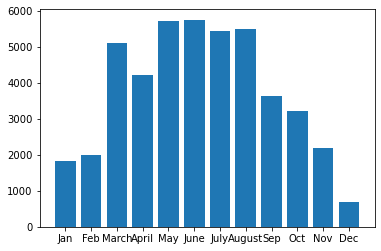

In [18]:
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "August", "Sep", "Oct", "Nov", "Dec"]
plt.bar(months, pvmodel.Outputs.monthly_energy)

## Running multiple scenarios

Now, we will evaluate multiple scenarios - we will look at a range of modules numbers and a range of strings to find minimum system requirements that satisfy maximum uptime

In [19]:
pvmodels_param_dict = []
pvmodels = []

In [20]:
%%time

# l = []  # for testing purposes

for m in range(2,8): # m is no of modules
    for n in range(4,15): # n is no of strings
        if m*n >=30:
#             l.append([m,n])
            pvmodels_param_dict.append({"modules_per_string" : m, "number_of_strings" : n})
            z = execute_pvmodel(m,n, n_inverters=5)
            pvmodels.append(z)

CPU times: user 35min 29s, sys: 18 s, total: 35min 47s
Wall time: 38min 37s


In [21]:
len(pvmodels)

41

In [22]:
pvmodels[0]

In [23]:
uptime_percent = []

for i in range(len(pvmodels)):
    uptime_hours = np.count_nonzero(
        (np.array(pvmodels[i].Outputs.system_to_load) + 
         np.array(pvmodels[i].Outputs.batt_to_load) - 
         np.tile(our_load_profile, 25)  # repeat load profile for 25 years
        ) == 0 
    )
    
    uptime_percent.append(uptime_hours/(365 * 24 * 25))

In [24]:
uptime_percent

[0.27878538812785386,
 0.2920365296803653,
 0.3039360730593607,
 0.31552054794520545,
 0.32601826484018265,
 0.28806392694063926,
 0.30411872146118724,
 0.31958447488584474,
 0.33178995433789954,
 0.34200456621004566,
 0.3510821917808219,
 0.35984474885844747,
 0.2791689497716895,
 0.30033789954337897,
 0.31980821917808216,
 0.334689497716895,
 0.34684931506849315,
 0.357958904109589,
 0.3680776255707763,
 0.37740182648401827,
 0.38531506849315067,
 0.27935159817351596,
 0.3044840182648402,
 0.3265616438356164,
 0.34227397260273973,
 0.35591324200913244,
 0.36827397260273975,
 0.37922374429223743,
 0.38858904109589043,
 0.3968812785388128,
 0.403337899543379,
 0.30069406392694065,
 0.3267214611872146,
 0.34488584474885847,
 0.36026940639269406,
 0.3740639269406393,
 0.3856255707762557,
 0.39572146118721463,
 0.4034109589041096,
 0.41012785388127854,
 0.4180091324200913]

In [25]:
pvmodels_param_dict

[{'modules_per_string': 3, 'number_of_strings': 10},
 {'modules_per_string': 3, 'number_of_strings': 11},
 {'modules_per_string': 3, 'number_of_strings': 12},
 {'modules_per_string': 3, 'number_of_strings': 13},
 {'modules_per_string': 3, 'number_of_strings': 14},
 {'modules_per_string': 4, 'number_of_strings': 8},
 {'modules_per_string': 4, 'number_of_strings': 9},
 {'modules_per_string': 4, 'number_of_strings': 10},
 {'modules_per_string': 4, 'number_of_strings': 11},
 {'modules_per_string': 4, 'number_of_strings': 12},
 {'modules_per_string': 4, 'number_of_strings': 13},
 {'modules_per_string': 4, 'number_of_strings': 14},
 {'modules_per_string': 5, 'number_of_strings': 6},
 {'modules_per_string': 5, 'number_of_strings': 7},
 {'modules_per_string': 5, 'number_of_strings': 8},
 {'modules_per_string': 5, 'number_of_strings': 9},
 {'modules_per_string': 5, 'number_of_strings': 10},
 {'modules_per_string': 5, 'number_of_strings': 11},
 {'modules_per_string': 5, 'number_of_strings': 12},

<BarContainer object of 12 artists>

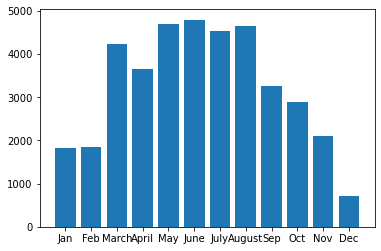

In [26]:
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "August", "Sep", "Oct", "Nov", "Dec"]
plt.bar(months, pvmodels[0].Outputs.monthly_energy)

In [27]:
(np.array(pvmodels[0].Outputs.system_to_load) + np.array(pvmodels[0].Outputs.batt_to_load) - np.tile(our_load_profile, 25))[-24:]

array([-0.726     , -0.726     , -0.726     , -0.726     , -0.726     ,
       -0.726     , -0.726     , -0.726     , -9.56955633, -7.14987875,
       -7.04909263, -7.87087892, -5.69753726, -8.47128446, -3.85718383,
       -9.63331519, -9.671     , -9.671     , -9.671     , -9.671     ,
       -0.726     , -0.726     , -0.726     , -0.726     ])